#### This notebook seeks to predicting sales at Walmart stores and departments based on data provided by Kaggle.
In the document, extraction, cleaning and exploratory data analysis were performed, as well as testing different machine learning algorithms, choosing the one with the least absolute error in the cross validation test.

In [1]:
#importing the required modules

import os
import itertools
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold



In [2]:
#import the given data sets

df_stores = pd.read_csv(r'C:\Users\E530C\Desktop\lux academy capstone\stores.csv')
df_features = pd.read_csv(r'C:\Users\E530C\Desktop\lux academy capstone\features.csv')
df_train = pd.read_csv(r'C:\Users\E530C\Desktop\lux academy capstone\train.csv')
df_test = pd.read_csv(r'C:\Users\E530C\Desktop\lux academy capstone\test.csv')

In [3]:
# We then merge the stores and features dataset to the train and test data set
df_merged_store = df_features.merge(df_stores, how = 'inner', on = 'Store')
df_merged_store.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [4]:
# merge the current df with both the train and test data
test_store = df_test.merge(df_merged_store, how='inner', on=['Store','Date','IsHoliday'])
test_store.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315


In [5]:
train_store = df_train.merge(df_merged_store, how='inner', on=['Store','Date','IsHoliday'])
train_store.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


### Explotary Data Analysis

#### To understand our data better, we carry out explotary data analysis.

In [6]:
#looking at missing values to start with
print('Percentages of missing values in features dataframe.')
(100*train_store.isna().sum()/train_store.shape[0]).sort_values()

Percentages of missing values in features dataframe.


Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
CPI              0.000000
Unemployment     0.000000
Type             0.000000
Size             0.000000
MarkDown5       64.079038
MarkDown1       64.257181
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown2       73.611025
dtype: float64

In [7]:
#given that Markdown 1,2,3,4,5 have a high percenatge of missing values, we drop them in this data set.
train_store = train_store.drop(['MarkDown5','MarkDown1', 'MarkDown3', 'MarkDown4', 'MarkDown2'], axis=1)
train_store.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,A,151315


In [8]:
test_store = test_store.drop(['MarkDown5','MarkDown1', 'MarkDown3', 'MarkDown4', 'MarkDown2'], axis=1)
test_store.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315
1,1,2,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315
2,1,3,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315
3,1,4,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315
4,1,5,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315


In [9]:
#We now proceed to work with the date column
train_store.Date = pd.to_datetime(train_store.Date)
test_store.Date = pd.to_datetime(test_store.Date)

In [10]:
test_store['Week'] = test_store.Date.dt.week 
test_store['Month'] = test_store.Date.dt.month
test_store['Year'] = test_store.Date.dt.year

train_store['Week'] = train_store.Date.dt.week
train_store['Month'] = train_store.Date.dt.month
train_store['Year'] = train_store.Date.dt.year
test_store.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week,Month,Year
0,1,1,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315,44,11,2012
1,1,2,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315,44,11,2012
2,1,3,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315,44,11,2012
3,1,4,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315,44,11,2012
4,1,5,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315,44,11,2012


In [11]:
train_store.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,Week,Month,Year
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,171.201947,7.960289,136727.915739,25.826762,6.449510,2010.968591
std,12.785297,30.492054,22711.183519,18.447931,0.458515,39.159276,1.863296,60980.583328,14.151887,3.243217,0.796876
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,132.022667,6.891000,93638.000000,14.000000,4.000000,2010.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,182.318780,7.866000,140167.000000,26.000000,6.000000,2011.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,212.416993,8.572000,202505.000000,38.000000,9.000000,2012.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,227.232807,14.313000,219622.000000,52.000000,12.000000,2012.000000


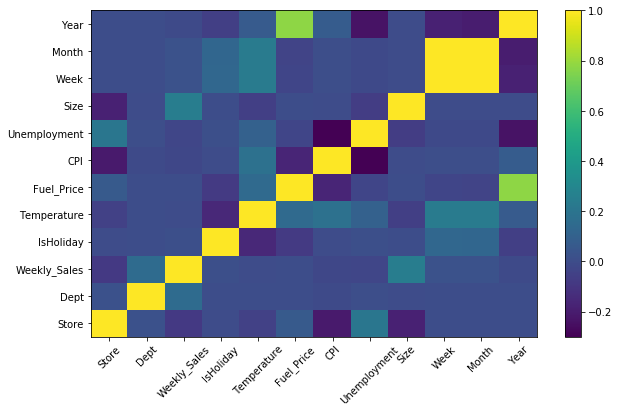

In [12]:
# checking for correlation

fig = plt.figure(figsize=(10, 6))
corr = train_store.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns, rotation=45)
fig.colorbar(c)

In [13]:
corr['Weekly_Sales'].sort_values()

Store          -0.085195
Unemployment   -0.025864
CPI            -0.020921
Year           -0.010111
Temperature    -0.002312
Fuel_Price     -0.000120
IsHoliday       0.012774
Week            0.027673
Month           0.028409
Dept            0.148032
Size            0.243828
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

In [14]:
# as seen above the store, unemployment, CPI, Year and Temperature donot really affect the weekly sales. These columns should 
#be dropped in both the test and train data sets.

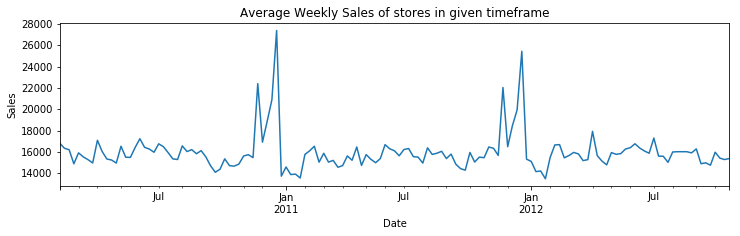

In [15]:
plt.figure(figsize=(12,3))
train_store.groupby('Date')['Weekly_Sales'].mean().plot()
plt.title('Average Weekly Sales of stores in given timeframe')
plt.ylabel('Sales');
plt.xlabel('Date');

#### It can clearly be seen that sales drastically spike towards the end of the year

In [16]:
train_store.groupby(['Year', 'Month','Date']).sum().sort_values('Weekly_Sales', ascending=False).head(10)

Store    Dept  Weekly_Sales  IsHoliday  Temperature  \
Year Month Date                                                              
2010 12    2010-12-24  65507  130460   80931415.60        0.0    119305.73   
2011 12    2011-12-23  67073  135571   76998241.31        0.0    118482.53   
     11    2011-11-25  66864  135801   66593605.26     3021.0    148385.60   
2010 11    2010-11-26  65217  129373   65821003.24     2938.0    139073.01   
     12    2010-12-17  65676  130438   61820799.85        0.0    117066.61   
2011 12    2011-12-16  66894  134714   60085695.94        0.0    122351.33   
2010 12    2010-12-10  65354  129960   55666770.39        0.0    113228.14   
2011 12    2011-12-09  66809  134656   55561147.70        0.0    114274.51   
2012 4     2012-04-06  66323  132587   53502315.87        0.0    168262.54   
     7     2012-07-06  65939  132367   51253021.88        0.0    236201.90   

                       Fuel_Price            CPI  Unemployment       Size  \
Year Month Date                                                             
2010 12    2010-12-24    8935.337  497015.727564     24919.923  404641025   
2011 12    2011-12-23    9969.810  525608.303281     23510.033  413071997   
     11    2011-11-25   10377.376  523217.406265     23448.206  412868802   
2010 11    2010-11-26    8576.822  494189.942609     24760.115  401656621   
     12    2010-12-17    8902.032  497291.416111     24951.637  404391197   
2011 12    2011-12-16   10051.569  522640.901213     23393.564  410196007   
2010 12    2010-12-10    8783.206  495279.546171     24844.754  403648007   
2011 12    2011-12-09   10123.057  521609.469923     23384.366  410091317   
2012 4     2012-04-06   11823.871  521758.598276     22071.292  406759729   
     7     2012-07-06   10256.210  518307.081097     21407.570  403641052   

                         Week  
Year Month Date                
2010 12    2010-12-24  150756  
2011 12    2011-12-23  154377  
     11    2011-11-25  141987  
2010 11    2010-11-26  138086  
     12    2010-12-17  147950  
2011 12    2011-12-16  150650  
2010 12    2010-12-10  144452  
2011 12    2011-12-09  147490  
2012 4     2012-04-06   41762  
     7     2012-07-06   79947

In [17]:
#Obtain holidays in our dataset
train_store[train_store['IsHoliday'] == True]['Date'].unique()


array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-02-10T00:00:00.000000000', '2012-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [18]:
train_store[train_store['IsHoliday'] == True]['Week'].unique()

array([ 6, 36, 47, 52], dtype=int64)

In [19]:
"""" the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13"""

'" the four holidays fall within the following weeks in the dataset (not all holidays are in the data):\n\nSuper Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\nLabor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\nThanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\nChristmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13'

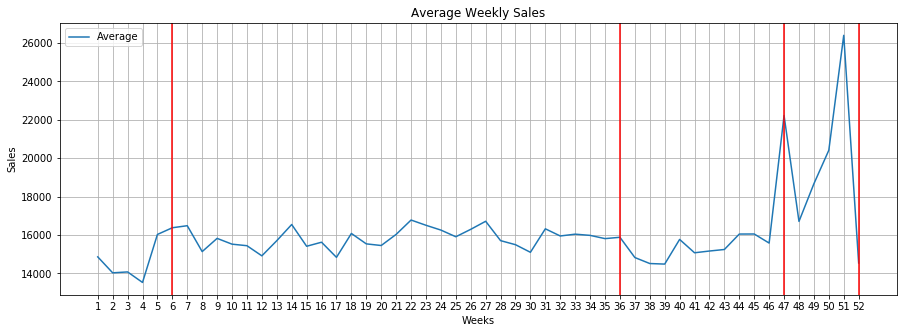

In [20]:
# do holidays affect sales?

weekly_sales_avg = train_store['Weekly_Sales'].groupby(train_store['Week']).mean()
plt.figure(figsize=(15,5))
sns.lineplot(weekly_sales_avg.index, weekly_sales_avg.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['Average'], loc='best')
plt.title('Average Weekly Sales')
plt.ylabel('Sales')
plt.xlabel('Weeks')
plt.axvline(6, color='red')
plt.axvline(36, color='red')
plt.axvline(47, color='red')
plt.axvline(52, color='red')
plt.show()


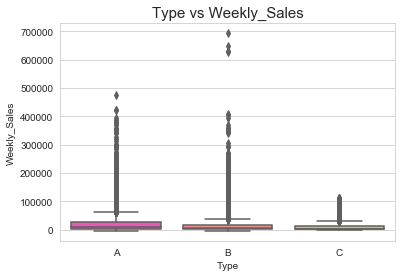

In [21]:
#How are the different store types performing?

sns.set_style('whitegrid')
sns.boxplot(x='Type',y='Weekly_Sales',data=train_store,palette='spring')
plt.title('Type vs Weekly_Sales',fontsize=15);

### Data Preparation

In [22]:
def categorical_to_norminal(x):
    if x == 'A':
        return 3
    elif x == 'B':
        return 2
    else:
        return 1
    
test_store.Type = test_store.Type.apply(categorical_to_norminal)
train_store.Type = train_store.Type.apply(categorical_to_norminal)


In [23]:
def bool_to_num(x):
    if x == 'True':
        return 1
    else:
        return 0
    
train_store.IsHoliday = train_store.IsHoliday.apply(bool_to_num)
test_store.IsHoliday = test_store.IsHoliday.apply(bool_to_num)

In [24]:
train_store = train_store.drop(['Date','CPI','Unemployment','Temperature','Fuel_Price'],axis=1)
test_store = test_store.drop(['Date','CPI','Unemployment','Temperature','Fuel_Price'],axis=1)
test_store.head()

,Store,Dept,IsHoliday,Type,Size,Week,Month,Year
0,1,1,0,3,151315,44,11,2012
1,1,2,0,3,151315,44,11,2012
2,1,3,0,3,151315,44,11,2012
3,1,4,0,3,151315,44,11,2012
4,1,5,0,3,151315,44,11,2012


In [25]:
# checking for null values
nulls = (train_store.isnull().sum(axis = 0)/len(train_store))*100
nulls

Store           0.0
Dept            0.0
Weekly_Sales    0.0
IsHoliday       0.0
Type            0.0
Size            0.0
Week            0.0
Month           0.0
Year            0.0
dtype: float64

In [26]:
# Training Model
y = train_store["Weekly_Sales"]
X = train_store.drop(['Weekly_Sales'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 101)


In [27]:
len(X_train), len(y_train) 

(295099, 295099)

In [28]:
model = RandomForestRegressor(n_estimators=50, max_depth=27, max_features=6, min_samples_split=2, min_samples_leaf=1)
model.fit(X_train, y_train)
preds = model.predict(X_train)
rmse_all = np.sqrt(mean_squared_error(y_train, preds))
acc_rf = round(model.score(X_train, y_train) * 100, 2)
print("RMSE: %f" % (rmse_all))
print ("Accuracy: %i %% \n"%acc_rf)

RMSE: 1317.245294
Accuracy: 99 % 



In [29]:
model = RandomForestRegressor(n_estimators=150)
model.fit(X_train, y_train)
preds= model.predict(X_train)
rmse_all = np.sqrt(mean_squared_error(y_train, preds))
acc_rf = round(model.score(X_train, y_train) * 100, 2)
print("RMSE: %f" % (rmse_all))
print ("Accuracy: %i %% \n"%acc_rf)

RMSE: 1259.138056
Accuracy: 99 % 



In [30]:
from numpy import absolute

In [31]:

model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 6960.176 (62.458)


#### Hyper tuning the model

In [32]:
n_estimators = [100,120,140]
max_depth = [25, 27, 30]
RandomForestRegressor(n_estimators, max_depth)

RandomForestRegressor(bootstrap=True, criterion=[25, 27, 30], max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0,
                      n_estimators=[100, 120, 140], n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [40]:
model = RandomForestRegressor(n_estimators=150, max_depth=27, max_features=6, min_samples_split=2, min_samples_leaf=1)
model.fit(X_train, y_train)
preds = model.predict(X_train)
rmse_all = np.sqrt(mean_squared_error(y_train, preds))
print("RMSE: %f" % (rmse_all))

RMSE: 1261.448843


#### Model Validation

In [47]:
sample_submission = pd.read_csv(r'C:\Users\E530C\Desktop\lux academy capstone\sampleSubmission.csv')

In [44]:
predicted = model.predict(test_store)

In [48]:
sample_submission['Weekly_Sales'] = predicted
sample_submission.to_csv('submission.csv',index=False)